Notebook to accompany paper in preparation by Arseniev-Koehler and Foster. All code last checked on Python 3 in Windows 5/30/2018. Please do not cite or reuse this code yet. This code is still in preparation and may contain errors.

# More Manly or Womanly? Measure Biases in Word2Vec Models with the Larsen Method

This project explores how language in the news is loaded with meanings of gender, morality, healthiness, and socio-economic status (SES). For example, which words are more masculine or feminine? Are certain words loaded with meanings of immorality or morality? 

In this code, we develop and then train a model to classify words with respect to each of these four dimensions (gender, morality, healthiness, and SES) on a set of training words. Then, we test model performance on a fresh set of testing words. 

Finally, we look at how language about body weight, such as "obese" and "slender,"  to see how these words are connoted with gender, morality, health, and social class. You might use this code to look at meanings of langauge in other arenas too - such as occupations, academic disciplines, or food. You might also extend this code to other types of meaning, or to other data sources. 

This notebook, Part C of our project, uses methods inspired by [Larsen et. al. 2016](https://arxiv.org/abs/1512.09300?context=cs). For two alternate methods to check the robustness of your findings, look at code for [Part B and Part D](https://github.com/arsena-k/Word2Vec-bias-extraction). 

We start by loading up a trained Word2Vec model on news. We suggest a pre-trained model if you don't have one, or see [Part A](https://github.com/arsena-k/Word2Vec-bias-extraction) of this project for a tutorial on training your own Word2Vec model.  


**Table of Contents**

* Part 1: [Load up libraries and a Word2Vec Model](#LoadUp)
* Part 2: [Explanation of Classification Method](#Motivation)
* Part 3: [Functions to Extract a Dimension](#HelperFunctions)
* Part 4: [Robustness Checks](#Robustness)
* Part 5: [Visualize how this Dimension Classifies words according to Gender, Morality, Health, and SES](#Results)

*This is a long notebook. For an abbreviated adventure, just do Parts 1-2 to get the ideas and see simple examples in Python,. Or, to just get to visualizing the results, do Parts 2, 4, and 5.*

<a id='LoadUp'></a>
# Part 1. Load up libraries and a Word2Vec Model

In [1]:
#load up (and install if needed) libraries
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold 
from gensim.models import Word2Vec
from sklearn import preprocessing
np.set_printoptions(threshold=np.inf) #do this if you want to print full output
from sklearn.decomposition import PCA #don't necessarily need
import csv
import gensim
import statistics
from random import randint
from collections import Counter
import matplotlib.pyplot as plt
from scipy import spatial
import seaborn as sns
from pylab import rcParams
from pylab import xlim
%matplotlib inline

C:\Users\Alina Arseniev\Anaconda3\lib\site-packages\gensim\utils.py:860: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


**Load up a pretrained Word2Vec Model**

*Don't have a model? Use a pretrained Word2Vec Model from Google, trained on Google News*
* Download a pre-trained model on GoogleNews, find link to download on this [site](https://code.google.com/archive/p/word2vec/) or direct link to [download here](https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit?usp=sharing).
* Extract the files, and make sure you have the one called "GoogleNews-vectors-negative300.bin.gz" in your working directory. Your working directory is the folder where this Jupyter notebook is currently saved. Currently, the code assumes that your downloads folder is your working directory. 
* Some of the vocabulary words used in this notebook may not exist, since the vocabulary words used in this notebook were selected based on a model trained on the New York Times, however the code will still run fine. 

In [ ]:
#   An example for a PC computer if your model is in your downloads folder, and you're using the Google model 
#currentmodel=  KeyedVectors.load_word2vec_format('C:/Users/Alina Arseniev/Downloads/GoogleNews-vectors-negative300.bin.gz', binary=True)

#   An example for a Mac if your model is in your downloads folder, and you're using the Google model 
#currentmodel=  KeyedVectors.load_word2vec_format("~/Downloads/GoogleNews-vectors-negative300.bin.gz", binary=True)

#   Example based on my set-up of folders:
currentmodel=  KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', binary=True)


*Have your own Word2Vec model? Load it up below.*
* If you don't have your own Word2Vec model, but have a large text dataset you want to train a model on, see [Part A](https://github.com/arsena-k/Word2Vec-bias-extraction) of this project for code to train a Word2Vec model.
* Some of the vocabulary words used in this notebook may not exist, since the vocabulary words used in this notebook were selected based on a model trained on the New York Times, however the code will still run fine. You might consider curating the words more to your vocabulary, especially if many words are missing in your vocabulary. 

In [2]:
#    An example for a PC computer if your model is in your downloads folder, and you're using a model named "modelA_ALLYEARS_500dim_10CW" 
#currentmodel=  Word2Vec.load("C:/Users/Alina Arseniev/Downloads/modelA_ALLYEARS_500dim_10CW")

#   An example for a Mac if your model is in your downloads folder, and you're using a model named "modelA_ALLYEARS_500dim_10CW" 
#currentmodel=  Word2Vec.load("~/Downloads/modelA_ALLYEARS_500dim_10CW")

#   Example based on my set-up of folders:
currentmodel=  Word2Vec.load("Word2VecModels/modelA_ALLYEARS_500dim_10CW") #load up a trained Word2Vec model. You'll need to tailor this path to your computer

<a id='Motivation'></a> 
# Part 2. Explanation of Classification Method

"Dimension," "direction" and "subspace" are used in this notebook interchangeably to refer to a vector that captures a bipolar concept such as gender which is often portrayed as ranging continuosly from hypermasculine to hyperfeminine, or socioeconomic status (SES) which ranges from poor to rich. 

This notebook explores how a language model (Word2Vec) **learns words with respect to these dimensions.** Word2Vec models words as numeric vectors, for a review of Word2Vec check out this [blog post](http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/). We classify a word-vector by first finding the dimension (like gender), and then projecting the word-vector onto the vector representing the dimension. We get a scalar that corresponds to how far the word-vector lies at one end of the diemsnion or anotehr (e.g., how masculine or feminine the word-vector is).
* To use gender as an example - a larger, positive projection of a word onto the gender dimension suggests this word is learned as highly feminine, while a larger, negative projection of a word onto the gender dimension suggests that this word is learned as highly masculine. A word with a projection near zero suggests that Word2Vec learned this word as gender-neutral. 
* Dimensions in this juypter notebook that are ready for extraction are **gender, morality, health,** and **ses**. Code is modifiable to extract other dimensions that may be interesting: you will need to adjust the training/testing words and corresponding labels. 
* This code is written for use with Word2Vec models, modifiable for other word-vector models as well. 

For a more detailed motivation, please see Part 1 of the Jupyter Notebook in this Repo titled "More Manly or Womanly? A Geometric Approach to Biases in Word2Vec Models." This notebook accomplishes the same things using a different method to extract a dimension. 


**Want MORE detail on how we can extract dimension (like gender)?**


Let's look at gender as an example. To extract a gender dimension, we want to find a direction (vector) that correspond to gender. We'll call this vector $\overrightarrow{g}$. This vector might be visualized as an axis ranging from negative (masculine) to positive (feminine) with gender-neutral at 0. We can find $\overrightarrow{g}$ by subtracting a direction representing femininity from a direction representing masculinity (such as $\overrightarrow{femininity}-\overrightarrow{masculinity}$). Specifically, if we assume that the meanings of masculinity and femininity are largely equivalent (both human, about adults, nouns, singular, etc.) except for their opposite gender components, then subtraction cancels out all but the gender differences across each component. This gender component is our gender direction ($\overrightarrow{g}$). 

This requires finding some direction for femininity and some direction for masculinity. We'll get to that next- for now, assume we have found these two directions.

Each vector (direction) in our model is made up of N components, where N is the dimensionality of the vector space. We can write each vector or word-vector in terms of these N components, below. For example, the first component is $\overrightarrow{X}$, the second component is $\overrightarrow{Y}$, and the Nth component is $\overrightarrow{N}$. For brevity, in the math below we refer to the direction for feminity as $\overrightarrow{f}$ and the direction for masculnity as $\overrightarrow{m}$.


$\overrightarrow{f} = f_{1}\overrightarrow{X} + f_{2}\overrightarrow{Y} + ... + f_{N}\overrightarrow{N}$
and 
$\overrightarrow{m} = m_{1}\overrightarrow{X} + m_{2}\overrightarrow{Y} + ... + m_{N}\overrightarrow{N}$


We assume that $\overrightarrow{f} - \overrightarrow{m}$ = $\overrightarrow{g}$, where $\overrightarrow{g}$ is a gender difference vector as described above.


$\overrightarrow{f} - \overrightarrow{m}$= $(f_{1}\overrightarrow{X} + f_{2}\overrightarrow{Y} + ... + f_{N}\overrightarrow{N}) - ( m_{1}\overrightarrow{X} + m_{2}\overrightarrow{Y} + ... + m_{N}\overrightarrow{N})$


These components may be rearranged:

$\overrightarrow{f} - \overrightarrow{m} = (f_{1}- m_{1})\overrightarrow{X} + (f_{2}- m_{2})\overrightarrow{Y} + ... + (f_{N} - m_{N})\overrightarrow{N}$

$\overrightarrow{f} - \overrightarrow{m} = g_{1}\overrightarrow{X} +  g_{2}\overrightarrow{Y} + ... + g_{N}\overrightarrow{N}$

This leaves us with a N-dimensional vector corresponding to the vector $\overrightarrow{g}$, corresponding to *differences* between $\overrightarrow{masculinity}$ and $\overrightarrow{femininity}$.

That's great but..how do we find the vectors for femininity and masculinity? Well, we COULD just use some proxies, like the word-vectors for "woman" and "man." 

In [ ]:
gender_direction_trial= currentmodel['woman']-currentmodel['man'] #subtracting the word-vector for man from that for woman
print(gender_direction_trial) #this "direction" representing gender is just an N-dimensional vector. Not so meaningful to a human!

**Now how do we use this gender direction to find how a word-vector is gendered?**
We [project](https://en.wikipedia.org/wiki/Vector_projection) the word-vector onto the gender direction! If you're not familiar with projections and want a visual explanation, please see Part 1 of the notebook in this repo titled "Geometrically_Extract_Dimensions_with_Word2Vec"

Let's try this. First, load up a few helper functions:

In [ ]:
#here's a forumla to project some vector A onto another vector B:
def project(A,B):
    numerator= A.dot(B) #should be a scalar
    denominator= np.linalg.norm(B,1) #should be another scalar
    scalarproject = float(numerator) / denominator #divide numerator by denominator, this gives you the scalar projection (LENGTH aka MAGNITUDE) of b onto a
    return scalarproject
    #if want to get the vector projection (i.e. magnutide and DIRECTION),  result 1 (MAGNITUDE) by vector a, and divded by (norm of A)^2

#here's a formula to make sure our vectors are all the same size 
def normalizeME(vec):
    b= vec.reshape(-1,1)
    c=b/np.linalg.norm(b, ord=2) 
    #print np.linalg.norm(1)
    return c

Do projections for a few words:

In [ ]:
scalarproject_fem_1 = project(currentmodel['queen'],normalizeME(gender_direction_trial)) 
scalarproject_fem_2 = project(currentmodel['womanly'],normalizeME(gender_direction_trial))
scalarproject_masc_1 = project(currentmodel['king'],normalizeME(gender_direction_trial))
scalarproject_masc_2 = project(currentmodel['manly'],normalizeME(gender_direction_trial))

In [ ]:
print(scalarproject_fem_1, scalarproject_fem_2, scalarproject_masc_1, scalarproject_masc_2) #take a look at the projections

If this is working on your trained Word2Vec model, you should see that the feminine words lie on one side of the gender direction, and the masculine words on the other side of the gender direction. In my model, for example, all the feminine words have positive scalar projections and all the masculine words have negative scalar projections. 

To find dimensions for other concepts, we just use other training words, like healthy-ill to find a "health" direction. Try it out by modifying the code above! 

### More realistically...

...this method captures the true gender difference alongside other differences and error. These proxies of "wooman" and "man" might not be so great, and so this method captures the true gender difference alongside other differences and error. Instead, we can use a variety of words representing femininity, such as she, her, and woman, and then take the *average* of these vectors to get a better proxy for femininity. We can do the same for masculiniity, and then subtract these two averages to get a better measure of our gender direction.

The remainder of this notebook does this, using a large set of training words. We look at three directions in this notebook: gender, morality, health, and SES. This notebook also includes steps to evaluate the robustness of the extracted direction on the training words, and on a new, unseen set of testing words. Finally, we project a new set of words (obesity keyword) onto the direction to see the meaning of obesity with respect to gender, morality, health, and SES.


### Now, let's extract a dimension more robustly

<a id='HelperFunctions'></a> 

# Part 3. Some Helper Functions to Extract a Dimension
* We choose a set of word pairs that best represent extremes of the dimennsions you are trying to capture. For example, we use man/woman, he/she, and uncle/aunt, among other word-pairs, to capture a gender dimension. 
* Words may be used more than once if there is no better antonym. Enter the words from each pair below, in order. 
* If you're not sure if your word choices are any good, try cross validation across the word possiblities to see how sensitive the process is to word choice. 

**First, a few helper functions to do a vector projection and normalize our vectors.**

In [3]:
def normalizeME(vec):
    b= vec.reshape(-1,1)
    c=b/np.linalg.norm(b, ord=2) 
    #print np.linalg.norm(1)
    return c
    
def project(A,B): #projection of A onto B
    numerator= A.dot(B) #should be a scalar
    denominator= np.linalg.norm(B,1) #should be another scalar
    scalarproject = numerator / denominator #divide numerator by denominator, this gives you the scalar projection (LENGTH aka MAGNITUDE) of b onto a
    return scalarproject
    #if want to get the vector projection (i.e. magnutide and DIRECTION),  result 1 (MAGNITUDE) by vector a, and divded by (norm of A)^2

**Second, a function to select the dimension and correponding words think represent the two ends of the dimension:**

If a word is not in the vocabulary of the model, this function by default lets you know and then replaces the word with a generic word. For example, if "teenage_girl", or "twin_sister" is not in the vocabulary they will be replaced with the generic feminine word for the gender scale, "woman."

You might prefer to change the generic replacement words, manually curate vocaublary words for your interests or model, or just remove word-pairs if one of the words in the pair doesn't exist. Later in this notebook we'll look at how robust the extracted dimension is to the choice of vocabulary words.

The training words below were used to capture gender, moral, health, or ses dimensions.

In [4]:
def select_training_set(trainingset): #options are: gender, moral, health, ses
    #gender is the training set used in corresponding paper
    #gender_2 has fewer precise gender words like "he" vs "she" than set 1,  and some more noise via words that are gendered but less clearcut than Set1)
    #gender_3 even fewer precise gender words like "he" vs "she" than set 1,  and same added noise as training set 2

    if trainingset=='gender_2':
        pos_word_list=[ 'girl', 'girls', 'her', 'hers', 'herself', 'she', 
            'lady', 'gal', 'gals', 'madame', 'ladies', 'lady',
          'mother', 'mothers', 'mom', 'moms', 'mommy', 'mama', 'ma', 'granddaughter', 'daughter', 'daughters', 'aunt', 'godmother', 
          'grandma', 'grandmothers', 'grandmother', 'sister', 'sisters', 'aunts', 'stepmother', 'granddaughters', 'niece',
        'fiancee', 'ex_girlfriend', 'girlfriends', 'wife', 'wives', 'girlfriend', 'bride', 'brides', 'widow',
           'twin_sister', 'younger_sister', 'teenage_girl', 'teenage_girls', 'eldest_daughter','estranged_wife', 'schoolgirl',
        'businesswoman', 'congresswoman' , 'chairwoman', 'councilwoman', 'waitress', 'hostess', 'convent', 'heiress', 
           'saleswoman', 'queen', 'queens', 'princess', 'nun' , 'nuns', 'heroine', 'actress', 'actresses', 'uterus', 'vagina', 'ovarian_cancer',
        'maternal', 'maternity', 'motherhood', 'sisterhood', 'girlhood', 'matriarch', 'sorority', 'mare', 'hen', 'hens', 'filly', 'fillies',
          'deer', 'older_sister', 'oldest_daughter', 'stepdaughter', 'pink',  'cute', 'dependent', 'nurturing', 'hysterical', 'bitch',  'dance', 'dancing'] 
        neg_word_list=['boy', 'boys', 'him', 'his', 'himself', 'he', 'guy', 'dude',
            'dudes', 'sir', 'guys', 'gentleman','father', 'fathers', 'dad', 'dads', 'daddy', 'papa', 'pa', 'grandson' , 'son', 'sons', 'uncle', 'godfather', 
        'grandpa', 'grandfathers', 'grandfather', 'brother', 'brothers' , 'uncles', 'stepfather', 'grandsons', 'nephew',
           'fiance', 'ex_boyfriend', 'boyfriends', 'husband', 'husbands', 'boyfriend', 'groom', 'grooms', 'widower',
            'twin_brother', 'younger_brother', 'teenage_boy', 'teenage_boys', 'eldest_son', 'estranged_husband', 'schoolboy',
            'businessman', 'congressman', 'chairman', 'councilman', 'waiter', 'host', 'monastery', 'heir', 'salesman', 
            'king', 'kings', 'prince', 'monk', 'monks', 'hero', 'actor', 'actors', 'prostate', 'penis', 'prostate_cancer', 
        'paternal', 'paternity', 'fatherhood', 'brotherhood', 'boyhood', 'patriarch', 'fraternity', 'stallion', 'rooster', 'roosters', 'colt',
           'colts', 'bull', 'older_brother', 'oldest_son', 'stepson', 'blue' ,'manly', 'independent', 'aggressive', 'angry', 'jerk', 'wrestle', 'wrestling'  ]
        pos_word_replacement='woman'
        neg_word_replacement='man'
    elif trainingset=='gender_3':
        pos_word_list=['madame', 'ladies', 'lady',
          'mother', 'mothers', 'mom', 'mama', 'granddaughter', 'daughter', 'daughters', 'aunt', 'godmother', 
          'grandma', 'grandmothers', 'grandmother', 'sister', 'sisters', 'aunts', 'stepmother', 'granddaughters', 'niece',
        'fiancee', 'ex_girlfriend', 'girlfriends', 'wife', 'wives', 'girlfriend', 'bride', 'brides', 'widow',
           'twin_sister', 'younger_sister', 'teenage_girl', 'teenage_girls', 'eldest_daughter','estranged_wife', 'schoolgirl',
        'businesswoman', 'congresswoman' , 'chairwoman', 'councilwoman', 'waitress', 'hostess', 'convent', 'heiress', 
           'saleswoman', 'queen', 'queens', 'princess', 'nun' , 'nuns', 'heroine', 'actress', 'actresses', 'uterus', 'vagina', 'ovarian_cancer',
        'maternal', 'maternity', 'motherhood', 'sisterhood', 'girlhood', 'matriarch', 'sorority', 'mare', 'hen', 'hens', 'filly', 'fillies',
          'deer', 'older_sister', 'oldest_daughter', 'stepdaughter', 'pink', 'cute', 'dependent', 'nurturing', 'hysterical', 'bitch',  'dance', 'dancing']
        neg_word_list=['sir', 'guys', 'gentleman','father', 'fathers', 'dad', 'papa', 'grandson' , 'son', 'sons', 'uncle', 'godfather', 
        'grandpa', 'grandfathers', 'grandfather', 'brother', 'brothers' , 'uncles', 'stepfather', 'grandsons', 'nephew',
           'fiance', 'ex_boyfriend', 'boyfriends', 'husband', 'husbands', 'boyfriend', 'groom', 'grooms', 'widower',
            'twin_brother', 'younger_brother', 'teenage_boy', 'teenage_boys', 'eldest_son', 'estranged_husband', 'schoolboy',
            'businessman', 'congressman', 'chairman', 'councilman', 'waiter', 'host', 'monastery', 'heir', 'salesman', 
            'king', 'kings', 'prince', 'monk', 'monks', 'hero', 'actor', 'actors', 'prostate', 'penis', 'prostate_cancer', 
        'paternal', 'paternity', 'fatherhood', 'brotherhood', 'boyhood', 'patriarch', 'fraternity', 'stallion', 'rooster', 'roosters', 'colt',
           'colts', 'bull', 'older_brother', 'oldest_son', 'stepson', 'blue' ,'manly', 'independent', 'aggressive', 'angry', 'jerk', 'wrestle', 'wrestling'  ]
        pos_word_replacement='woman'
        neg_word_replacement='man'
    elif trainingset=='gender':
        pos_word_list=['womanly', 'my_wife', 'my_mom', 'my_grandmother', 'woman', 'women', 'girl', 'girls', 'her', 'hers', 'herself', 'she', 
            'lady', 'gal', 'gals', 'madame', 'ladies', 'lady',
          'mother', 'mothers', 'mom', 'moms', 'mommy', 'mama', 'ma', 'granddaughter', 'daughter', 'daughters', 'aunt', 'godmother', 
          'grandma', 'grandmothers', 'grandmother', 'sister', 'sisters', 'aunts', 'stepmother', 'granddaughters', 'niece',
          'fiancee', 'ex_girlfriend', 'girlfriends', 'wife', 'wives', 'girlfriend', 'bride', 'brides', 'widow',
           'twin_sister', 'younger_sister', 'teenage_girl', 'teenage_girls', 'eldest_daughter','estranged_wife', 'schoolgirl',
          'businesswoman', 'congresswoman' , 'chairwoman', 'councilwoman', 'waitress', 'hostess', 'convent', 'heiress', 
           'saleswoman', 'queen', 'queens', 'princess', 'nun' , 'nuns', 'heroine', 'actress', 'actresses', 'uterus', 'vagina', 'ovarian_cancer',
           'maternal', 'maternity', 'motherhood', 'sisterhood', 'girlhood', 'matriarch', 'sorority', 
         'older_sister', 'oldest_daughter', 'stepdaughter']
        neg_word_list=['manly', 'my_husband', 'my_dad','my_grandfather', 'man', 'men', 'boy', 'boys', 'him', 'his', 'himself', 'he', 'guy', 'dude',
            'dudes', 'sir', 'guys', 'gentleman','father', 'fathers', 'dad', 'dads', 'daddy', 'papa', 'pa', 'grandson' , 'son', 'sons', 'uncle', 'godfather', 
           'grandpa', 'grandfathers', 'grandfather', 'brother', 'brothers' , 'uncles', 'stepfather', 'grandsons', 'nephew',
           'fiance', 'ex_boyfriend', 'boyfriends', 'husband', 'husbands', 'boyfriend', 'groom', 'grooms', 'widower',
            'twin_brother', 'younger_brother', 'teenage_boy', 'teenage_boys', 'eldest_son', 'estranged_husband', 'schoolboy',
            'businessman', 'congressman', 'chairman', 'councilman', 'waiter', 'host', 'monastery', 'heir', 'salesman', 
            'king', 'kings', 'prince', 'monk', 'monks', 'hero', 'actor', 'actors', 'prostate', 'penis', 'prostate_cancer', 
           'paternal', 'paternity', 'fatherhood', 'brotherhood', 'boyhood', 'patriarch', 'fraternity', 
           'older_brother', 'oldest_son', 'stepson']
        pos_word_replacement='woman'
        neg_word_replacement='man'
    elif trainingset=='moral':
        pos_word_list= ['good', 'benevolent', 'nice', 'caring', 'conscientious', 'polite', 'fair', 'virtue', 'respect', 'responsible', 
            'selfless', 'unselfish', 'sincere', 'truthful', 'wonderful', 'justice', 'innocent', 'innocence',
           'complement', 'sympathetic', 'virtue', 'right', 'proud', 'pride','respectful', 'appropriate', 'pleasing', 'pleasant', 
            'pure', 'decent', 'pleasant', 'compassion' , 'compassionate', 'constructive','graceful', 'gentle', 'reliable',
           'careful', 'help', 'decent' , 'moral', 'hero', 'heroic', 'heroism', 'honest', 'honesty',
           'selfless', 'humility', 'humble', 'generous', 'generosity', 'faithful', 'fidelity', 'worthy', 'tolerant',
            'obedient', 'pious', 'saintly', 'angelic', 'virginal', 'sacred', 'reverent', 'god', 'hero', 'heroic', 
            'forgiving', 'saintly','holy', 'chastity', 'grateful', 'considerate', 'humane', 
            'trustworthy', 'loyal', 'loyalty', 'empathetic', 'empathy', 'clean', 'straightforward', 'pure']
        neg_word_list= ['bad', 'evil', 'mean', 'uncaring', 'lazy', 'rude', 'unfair', 'sin', 'disrespect','irresponsible', 
           'self_centered', 'selfish', 'insincere', 'lying', 'horrible', 'injustice', 'guilty', 'guilt', 
            'insult', 'unsympathetic', 'vice', 'wrong', 'ashamed', 'shame', 'disrespectful', 'inappropriate', 'vulgar', 'crude', 
            'dirty', 'obscene', 'offensive', 'cruelty','brutal', 'destructive', 'rude', 'harsh', 'unreliable',
            'careless', 'harm', 'indecent', 'immoral', 'coward', 'cowardly', 'cowardice', 'dishonest', 'dishonesty',
            'narcissistic', 'arrogance', 'arrogant', 'greedy', 'greed', 'betray', 'betrayal', 'unworthy', 'intolerant', 
             'defiant', 'rebellious', 'demonic','devilish', 'promiscuous', 'profane', 'irreverent', 'devil', 'villain', 'villainous', 
            'vindictive', 'diabolical', 'unholy', 'promiscuity', 'ungrateful', 'thoughtless', 'inhumane',
            'untrustworthy', 'treacherous', 'treachery', 'callous', 'indifference', 'dirty', 'manipulative', 'impure' ]
        pos_word_replacement='moral'
        neg_word_replacement='immoral'
    elif trainingset=='health':
        pos_word_list= ['fertile', 'help_prevent', 'considered_safe', 'safer', 'healthy', 'healthy', 'healthy', 'healthy', 'healthy',
            'healthful', 'well_balanced', 'natural', 'healthy', 'athletic','physically_active', 'health',
            'health', 'nutritious','nourishing', 'stronger', 'strong','wellness', 'safe', 'nutritious_food','exercise',
            'physically_fit', 'unprocessed', 'healthier_foods', 'nutritious_foods', 'nutritious', 'nutritious',
           'healthy_eating', 'healthy_diet', 'healthy_diet', 'nourishing', 'nourished', 'regular_exercise', 'safety', 'safe', 
            'helpful', 'beneficial', 'healthy', 'healthy', 'sturdy', 'lower_risk', 'reduced_risk', 'decreased_risk', 'nutritious_foods', 'whole_grains', 'healthier_foods',
            'healthier_foods', 'physically_active', 'physical_activity', 'nourished', 'vitality', 'energetic', 'able_bodied',
            'resilience', 'strength', 'less_prone', 'sanitary', 'clean',  'healing', 'heal', 'salubrious']   
        neg_word_list= ['infertile', 'cause_harm','potentially_harmful','riskier', 'unhealthy', 'sick', 'ill', 'frail', 'sickly', 
            'unhealthful','unbalanced', 'unnatural', 'dangerous', 'sedentary', 'inactive', 'illness', 
            'sickness', 'toxic', 'unhealthy', 'weaker', 'weak', 'illness', 'unsafe', 'unhealthy_foods', 'sedentary',
            'inactive', 'highly_processed', 'processed_foods', 'junk_foods', 'unhealthy_foods', 'junk_foods',
               'processed_foods', 'processed_foods', 'fast_food', 'unhealthy_foods', 'deficient', 'sedentary', 'hazard','hazardous', 
            'harmful', 'injurious',  'chronically_ill', 'seriously_ill', 'frail', 'higher_risk', 'greater_risk', 'increased_risk', 'fried_foods', 'fried_foods',
            'fatty_foods', 'sugary_foods', 'sedentary', 'physical_inactivity', 'malnourished', 'lethargy', 'lethargic', 'disabled',
            'susceptibility', 'weakness', 'more_susceptible', 'filthy', 'dirty', 'harming', 'hurt', 'deleterious']
        pos_word_replacement='healthy'
        neg_word_replacement='ill'
    elif trainingset=='ses':
        pos_word_list=['wealth', 'wealthier', 'wealthiest', 'affluence', 'prosperity', 'wealthy', 'affluent', 'affluent', 'prosperous',
                'prosperous','prosperous','disposable_income',  'wealthy','suburban','luxurious','upscale','upscale', 'luxury', 
                'richest', 'privileged', 'moneyed', 'privileged', 'privileged', 'educated', 'employed', 
                'elite', 'upper_income', 'upper_class', 'employment', 'riches', 'millionaire', 'aristocrat', 'college_educated',
                'abundant', 'lack', 'luxury', 'profitable', 'profit', 'well_educated', 'elites', 'heir', 'well_heeled', 
                'white_collar', 'higher_incomes', 'bourgeois', 'fortunate', 'successful','economic_growth', 'prosper', 'suburbanites']
        neg_word_list= ['poverty', 'poorer', 'poorest', 'poverty', 'poverty', 'impoverished', 'impoverished',  'needy',  'impoverished',
                 'poor', 'needy', 'broke', 'needy', 'slum', 'ghetto', 'slums', 'ghettos', 'poor_neighborhoods', 
                'poorest', 'underserved', 'disadvantaged','marginalized', 'underprivileged', 'uneducated', 'unemployed', 
                'marginalized', 'low_income', 'underclass','unemployment', 'rags', 'homeless', 'peasant', 'college_dropout', 
                'lacking', 'abundance', 'squalor', 'bankrupt', 'debt', 'illiterate' ,'underclass', 'orphan',  'destitute', 
                'blue_collar', 'low_income', 'neediest', 'less_fortunate', 'unsuccessful', 'economic_crisis', 'low_wage', 'homeless']
        pos_word_replacement='wealthy'
        neg_word_replacement='poor'
    pos_words=[]
    neg_words=[]
    pos_word_list_checked=[]
    neg_word_list_checked=[]
    for i in pos_word_list:
        try:
            pos_words.append(currentmodel[i])
            pos_word_list_checked.append(i)
        except KeyError:
            #print(str(i) +  ' was not in this Word2Vec models vocab, and has been replaced with: ' + str(pos_word_replacement) ) #uncomment this to be alerted each time a training word doesn't exist in your model vocab
            pos_words.append(currentmodel[pos_word_replacement])
            pos_word_list_checked.append(pos_word_replacement)
    for i in neg_word_list:
        try:
            neg_words.append(currentmodel[i])
            neg_word_list_checked.append(i)
        except KeyError:
            #print(str(i) +  ' was not in this Word2Vec models vocab, and has been replaced with: ' + str(neg_word_replacement) ) #uncomment this to be alerted each time a training word doesn't exist in your model vocab
            neg_words.append(currentmodel[neg_word_replacement])
            neg_word_list_checked.append(neg_word_replacement)

    print("Number of pos words: " + str(len(pos_words)) + " Number of neg words: " + str(len(neg_words)))
    train_classes_pos=np.array(np.repeat(1, len(pos_words)).tolist()) #1 is feminine/moral/healthy/rich by default, we will need to find the correct labels inductively
    train_classes_neg=np.array(np.repeat(0, len(neg_words)).tolist()) #0 is masculine/immoral/unhealthy/poor by default, we will need to find the correct labels inductively
    
    pos_words=np.asarray(pos_words)
    neg_words= np.asarray(neg_words)
    return(pos_word_list_checked, neg_word_list_checked, pos_words, neg_words, train_classes_pos, train_classes_neg)

### A function to take the mean of a set of word-vectors 

This function returns a "direction" which is the average of a set of vectors. For example, given the gender training word-vectors, it returns the mean of these which is our feminine direction.

In [5]:
def MEAN_get_directionVec_unipolar(words, currentmodel, train_index_list=None):
    if train_index_list is not None:
        Ndiff=len(words[train_index_list])
        biggie2= np.reshape(words[train_index_list], (Ndiff,len(currentmodel['word']))) #now a Ndiff by #dimensions, menasured by len(currentmodel['word']), matrix, can check with print(biggie2.shape)
    else:
        Ndiff= len(words) 
        biggie2= np.reshape(words, (Ndiff,len(currentmodel['word']))) #now a Ndiff by #dimensions, menasured by len(currentmodel['word']), matrix, can check with print(biggie2.shape)
    biggie2= preprocessing.normalize(biggie2, norm='l2')

    all_vecs_mat= [] #this will be used to make the covariance matrix, cov_mat
    for i in range(0,Ndiff):
        all_vecs_mat.append(biggie2[i,:])
        
    direction = np.mean(all_vecs_mat,0)
    assert direction.shape == (len(currentmodel['word']),)
    extracteddirectionVec= np.hstack(normalizeME(direction)) #ensure normalized 
    return(extracteddirectionVec)

In [6]:
def MEAN_get_directionVec_differences(pos_words_, neg_words_, currentmodel, train_index_list=None):
    return(MEAN_get_directionVec_unipolar(pos_words_, currentmodel, train_index_list)- MEAN_get_directionVec_unipolar(neg_words_, currentmodel, train_index_list))    

<p> <span style="color:blue">**AT THIS POINT,** </span> you can continue to Part 4 to examine the robustness of these methods, or skip right to [Part 5](#Results) to just get to some results. <p>
 

<a id='Robustness'></a> 
# Part 4. Robustness Checks

**First, let's see how robust our methods are to the specific training words we use. We'll do cross validation on training words:**

Select the dimension you are interested in (gender, moral, health, or ses)

In [7]:
pos_word_list, neg_word_list, pos_words, neg_words, train_classes_pos, train_classes_neg \
    = select_training_set('gender')

Number of pos words: 85 Number of neg words: 85


Do **cross validation** to see how accuracy changes at classifying words if we just use a subset of training words to extract the dimension and and look at how the dimension classifies that subset of words and how it classifes the held-out words. This tells us, for example, how robust our methods are to our word choices. 

In [159]:
#cross validation
kf= KFold(n_splits=len(pos_words), shuffle=True) 
#n_splits written here is leave-one-wordpair-out cross validation, which is the maximum for n_splits. Try various quantities of n_splits. 
#Note that this cross-validaton is by word-pair, so if we leave out one word-pair from the direction extraction process, 
#we leave out two words on which to "test," giving two test predictions.
#NOTE that we are only using our training words here, but dividing it into a "sub" training set, and an unseen set of the trainign words, we call in this code block the "test" set. But we do not use our unseen true "test" words until later on. 

testacc=[]
trainacc=[]

for train_index, test_index in kf.split(pos_words): #only need the indices on pos words or neg words, then will be the same indices to use for both    
    directionVec= MEAN_get_directionVec_differences(pos_words, neg_words, currentmodel, train_index_list=train_index)
    #In a given model, we don't initially know the "direction" of a dimensions. In other words, we don't know whether a positive projection will be feminine or masculine. So, inductively find the correct labels 1/0. 
    #Consider this assumption that embedded in the code carefully when interpreting accuracy rates  
    #We learn this rule on the training model and then apply it on the fresh unseen testing model to make sure we're really detecting something.   
    pos_class=[] 
    for word in range(0, len(train_classes_pos[train_index])): #for word in this set of training words
        wordToProject=np.hstack(normalizeME(pos_words[train_index][word]))
        proj=project(wordToProject, directionVec)
        if proj > 0:
            pos_class.append(1) #evidence from this training word that the "positive words" are learned as positive
        elif proj < 0:
            pos_class.append(0) #evidence from this training word that the "positive words" are learned as negative
    
    #Now get predictions on the "training" set of the fold
    predictions_train=[]
    combinedposnegtrain= np.concatenate([pos_words[train_index] ,neg_words[train_index]], axis=0)
    if statistics.mode(pos_class)==1: #if the positive class is mostly 1, keep labels as is. Note that if the positive class is split exactly 50/50 this won't work, but also then accuracy is equal to flip of coin.    
        for word in range(0, len(combinedposnegtrain)):
            wordToProject=np.hstack(normalizeME(combinedposnegtrain[word]))
            proj=project(wordToProject, directionVec)
            if proj > 0:
                predictions_train.append(1)
            elif proj<0:
                predictions_train.append(0)
        classes_train= np.concatenate([train_classes_pos[train_index] , train_classes_neg[train_index]], axis=0)
    elif statistics.mode(pos_class)==0: #if the positive class is mostly -1, reverse labels
        for word in range(0, len(combinedposnegtrain)):
            wordToProject=np.hstack(normalizeME(combinedposnegtrain[word]))
            proj=project(wordToProject, directionVec)
            if proj > 0:
                predictions_train.append(0)
            elif proj<0:
                predictions_train.append(1)
        classes_train= np.concatenate([train_classes_pos[train_index] , train_classes_neg[train_index]], axis=0)
    else:
        print("No clear label")
    
    #Now get predictions on the "testing" set of the fold
    predictions_test=[]
    combinedposnegtest= np.concatenate([pos_words[test_index] ,neg_words[test_index]], axis=0)
    if statistics.mode(pos_class)==1:
        for word in range(0, len(combinedposnegtest)):
            wordToProject=np.hstack(normalizeME(combinedposnegtest[word]))
            proj=project(wordToProject, directionVec)
            if proj > 0:
                predictions_test.append(1)
            elif proj< 0:
                predictions_test.append(0)
        classes_test= np.concatenate([train_classes_pos[test_index], train_classes_neg[test_index]], axis=0)
    elif statistics.mode(pos_class)==0:
        for word in range(0, len(combinedposnegtest)):
            wordToProject=np.hstack(normalizeME(combinedposnegtest[word]))
            proj=project(wordToProject, directionVec)
            if proj > 0:
                predictions_test.append(0)
            elif proj< 0:
                predictions_test.append(1)
        classes_test= np.concatenate([train_classes_pos[test_index], train_classes_neg[test_index]], axis=0)
    else:
        print("No clear label")
    trainacc.append(accuracy_score(classes_train, predictions_train))
    testacc.append(accuracy_score(classes_test, predictions_test))
    
print('\033[1m' +'Mean Accuracy across Training Subsets:'  + '\033[0m'+ str(statistics.mean(trainacc)))
print('\033[1m' +'Standard Deviation of Accuracy across Training Subsets:'  + '\033[0m'+ str(statistics.stdev(trainacc)))
print('\033[1m' +  'Mean Accuracy across Held-Out Subsets: ' + '\033[0m'+ str(statistics.mean(testacc)))
print('\033[1m' +'Standard Deviation of Accuracy across Held-Out Subsets: ' + '\033[0m' + str(statistics.stdev(testacc)))

### Let's look to see if these directions are unique 

Perhaps they are all just capturing sentiment (good vs bad)?

In [9]:
#extract all four direction vectors:
pos_word_list, neg_word_list, pos_words, neg_words, train_classes_pos, train_classes_neg = select_training_set('gender')
genderdirectionVec= MEAN_get_directionVec_differences(pos_words, neg_words, currentmodel, train_index_list=None)

pos_word_list, neg_word_list, pos_words, neg_words, train_classes_pos, train_classes_neg = select_training_set('moral')
moraldirectionVec= MEAN_get_directionVec_differences(pos_words, neg_words, currentmodel, train_index_list=None)

pos_word_list, neg_word_list, pos_words, neg_words, train_classes_pos, train_classes_neg = select_training_set('health')
healthdirectionVec= MEAN_get_directionVec_differences(pos_words, neg_words, currentmodel, train_index_list=None)

pos_word_list, neg_word_list, pos_words, neg_words, train_classes_pos, train_classes_neg = select_training_set('ses')
sesdirectionVec= MEAN_get_directionVec_differences(pos_words, neg_words, currentmodel, train_index_list=None)

Number of pos words: 85 Number of neg words: 85
Number of pos words: 80 Number of neg words: 80
Number of pos words: 65 Number of neg words: 65
Number of pos words: 50 Number of neg words: 50


In [174]:
print("Cosine Similarity between gender and morality is: " + str(1 - spatial.distance.cosine(genderdirectionVec, moraldirectionVec))) #similarity is 1-distance
print("Cosine Similarity between gender and health is: " + str(1 - spatial.distance.cosine(genderdirectionVec, healthdirectionVec))) #similarity is 1-distance
print("Cosine Similarity between gender and ses is: " + str(1 - spatial.distance.cosine(genderdirectionVec, sesdirectionVec))) #similarity is 1-distance
print("Cosine Similarity between morality and health is: " + str(1 - spatial.distance.cosine(moraldirectionVec, healthdirectionVec))) #similarity is 1-distance
print("Cosine Similarity between morality and ses is: " + str(1 - spatial.distance.cosine(moraldirectionVec, sesdirectionVec))) #similarity is 1-distance
print("Cosine Similarity between health and ses is: " + str(1 - spatial.distance.cosine(healthdirectionVec, sesdirectionVec))) #similarity is 1-distance

Cosine Similarity between gender and morality is: 0.101269733294
Cosine Similarity between gender and health is: 0.125955690315
Cosine Similarity between gender and ses is: -0.0597965205425
Cosine Similarity between morality and health is: 0.702924952102
Cosine Similarity between morality and ses is: 0.307713178627
Cosine Similarity between health and ses is: 0.242734038091


From Word2Vec models used to develop this code, morality and health are quite similar, though not exactly the same. Gender is not similar to any others, and health, morality, and ses have some similarity. Perhaps another future route to improve these dirctions even more is to find a "sentiment" direction, and find the each the vector *rejection* of morality, health, and SES on to sentiment, to "eliminate" sentiment. 

In [112]:
np.savetxt("genderdirectionVec_altMEAN.csv", genderdirectionVec, delimiter=",") #if you want to save a direction vector you extracted!
np.savetxt("moraldirectionVec_altMEAN.csv", moraldirectionVec, delimiter=",") #if you want to save a direction vector you extracted!
np.savetxt("healthdirectionVec_altMEAN.csv", healthdirectionVec, delimiter=",") #if you want to save a direction vector you extracted!
np.savetxt("sesdirectionVec_altMEAN.csv", sesdirectionVec, delimiter=",") #if you want to save a direction vector you extracted!

<a id='Results'></a> 
# Part 5: Let's extract a dimension (gender, morality, health, or socioeconomic status) and then see how words are classified according to that dimension

For each dimension, we'll look at how the dimension classifies the **training** words used to find the dimension and then a fresh set of **testing** words *not* used to find the dimension.

For gender, we'l look at how the dimension classifies some **stereotypically gendered** words, and you can try adding in our own words too. 

Finally, we'll look at how the dimension classifies a set of **words about obesity and body weight**. Is obesity connoted with feminininity or masculinity? Morality or immorality? Health or illness? Wealth or poverty?  Here you can stick in your own words too and see how they are classified. 

Let's get started by defining some more functions:

In [10]:
#a function to select a testing set of words
def select_testing_set(testingset):
    if testingset=='gender':
        test_word_list= ['goddess', 'single_mother', 'girlish', 'feminine', 'young_woman', 'little_girl', 'ladylike', 'my_mother', 
           'teenage_daughter', 'mistress', 'great_grandmother', 'adopted_daughter', 'femininity', 'motherly', 'matronly', 
           'showgirl', 'housewife', 'vice_chairwoman', 'co_chairwoman', 'spokeswoman', 'governess', 'divorcee', 'spinster', 
           'maid', 'countess', 'pregnant_woman', 'landlady', 'seamstress', 'young_girl', 'waif', 'femme_fatale','comedienne',
            'boyish', 'masculine',  'lad', 'policeman', 'macho', 'gentlemanly', 'machismo',  'teenage_son', 
            'beau', 'great_grandfather', 'tough_guy', 'masculinity', 'bad_boy', 'spokesman', 'baron', 'adult_male', 'landlord', 'fireman', 'mailman', 'vice_chairman', 
           'co_chairman','young_man', 'bearded', 'mustachioed', 'con_man', 'homeless_man', 'gent', 'strongman']
        test_classes=np.repeat(1, 32).tolist() #1 is feminine
        masc2=np.repeat(0, 28).tolist() #0 is masculine
        for i in masc2:
            test_classes.append(i) 
    elif testingset=='moral':
        test_word_list= ['great', 'best', 'faith', 'chaste', 'wholesome', 'noble', 'honorable', 'immaculate', 'gracious', 
           'courteous', 'delightful', 'earnest', 'amiable', 'admirable', 'disciplined', 'patience', 'integrity',
            'restraint', 'upstanding', 'diligent', 'dutiful', 'loving', 'righteous','respectable', 'praise', 'devout', 'forthright',
            'depraved', 'repulsive', 'repugnant', 'corruption', 'vicious', 'unlawful', 'outrage',  'shameless', 'perverted',
            'filthy', 'lewd', 'subversive', 'sinister', 'murderous', 'perverse', 
           'monstrous', 'homicidal', 'indignant', 'misdemeanor', 'degenerate', 'malevolent', 'illegal','terrorist','terrorism',  
             'cheated', 'vengeful', 'culpable','vile', 'hateful', 'abuse', 'abusive', 'criminal', 'deviant']
        test_classes=np.repeat(1, 27 ).tolist() #1 is feminine
        masc2=np.repeat(0,33).tolist() #0 is masculine
        for i in masc2:
            test_classes.append(i)
    elif testingset=='health':
        test_word_list= [ 'balanced_diet', 'healthfulness', 'fiber', 'jogging', 'stopping_smoking', 'vigor', 
          'active', 'fit', 'flourishing', 'sustaining', 'hygienic', 'hearty', 'enduring', 'energized', 'wholesome', 
           'holistic', 'healed', 'fitter', 'health_conscious', 'more_nutritious', 'live_longer',  'exercising_regularly',
           'healthier_choices', 'healthy_habits', 'healthy_lifestyle', 'healthful_eating', 'immune', 
            'deadly', 'diseased',  'adverse', 'risky', 'fatal', 'filthy', 'epidemic', 'crippling', 'carcinogenic', 'carcinogen',
           'crippled', 'afflicted', 'contaminated', 'fatigued', 'detrimental', 'bedridden', 'incurable', 'hospitalized',
           'infected', 'ailing', 'debilitated', 'poisons', 'disabling', 'life_threatening', 'debilitating', 
           'chronic_illness', 'artery_clogging', 'hypertension','disease', 'stroke',
            'plague', 'fatty', 'smoking']
        test_classes=np.repeat(1, 27).tolist() #1 is feminine
        masc2=np.repeat(0, 33 ).tolist() #0 is masculine
        for i in masc2:
            test_classes.append(i) 
    elif testingset=='ses':
        test_word_list= ['rich', 'billionaire', 'banker',  'fortune', 'heiress', 'cosmopolitan', 'ornate', 'entrepreneur', 'sophisticated',
                'aristocratic', 'investor', 'highly_educated', 'better_educated',  'splendor', 
               'businessman', 'opulent', 'multimillionaire', 'philanthropist', 'estate', 'estates', 'chateau', 'fortunes', 
               'financier', 'young_professionals','tycoon', 'baron', 'grandeur', 'magnate', 
               'investment_banker', 'venture_capitalist', 'upwardly_mobile', 'highly_skilled', 'yuppies', 'genteel',
                         'homelessness', 'ruin', 'ruined', 'downtrodden', 'less_affluent',
                'housing_project', 'homeless_shelters', 'indigent', 'jobless', 'welfare',  
                'temporary_shelters','housing_projects', 'subsidized_housing', 'starving', 'beggars', 'orphanages',
                'dispossessed', 'uninsured', 'welfare_recipients', 'food_stamps', 
                'malnutrition',  'underemployed', 'disenfranchised', 'servants', 'displaced', 'poor_families'] 
        test_classes=np.repeat(1, 34).tolist()#1 is feminine
        masc2=np.repeat(0, 26).tolist() #0 is masculine
        for i in masc2:
            test_classes.append(i) 
    elif testingset=='gender_stereotypes':
        test_word_list=['petite', 'cooking', 'graceful',  'housework', 'soft', 'whisper', 'flirtatious', 'accepting', 'blonde', 'blond', 'doll', 'dolls','nurse',  'estrogen', 'lipstick','pregnant', 'nanny', 'pink', 
                 'sewing', 'modeling', 'dainty', 'gentle', 'children','pregnancy', 'nurturing', 'depressed', 'nice', 'emotional','depression', 'home', 'kitchen', 'quiet', 'submissive',
                   'soldier', 'army', 'drafted', 'military',   'beard', 'mustache', 'genius', 'engineering', 'math', 
                  'brilliant', 'strong', 'strength',  'politician', 'programmer','doctor', 'sexual', 'aggressive', 
                    'testosterone', 'tall', 'competitive', 'big', 'powerful', 'mean', 'sports', 'fighting', 'confident', 'rough', 'loud', 'worldly',
                   'experienced', 'insensitive', 'ambitious', 'dominant']
        test_classes=np.repeat(1, 33 ).tolist() #1 is feminine
        masc2=np.repeat(0,33).tolist() #0 is masculine
        for i in masc2:
            test_classes.append(i) 
    else:
        print('choose a testing set: gender, moral, health, ses, or gender_stereotypes')
        
    test_words=[]
    test_word_list_checked=[]
    test_classes_checked=[] 
    for i in test_word_list:
        try:
            test_words.append(currentmodel[i])
            test_word_list_checked.append(i)
            test_classes_checked.append(test_classes[test_word_list.index(i)]) #new
        except KeyError:
            continue
            #print(str(i) +  ' was not in this Word2Vec models vocab, and has been removed as a test word')
            #index_missing= test_word_list.index(i)
            #del(test_classes[index_missing])
            #test_words.append(currentmodel[test_word_replacement])
            #test_word_list_checked.append(test_word_replacement)
            #get index of word, and remove this from classes, and do not append to list of vectors and word-list

    test_words= np.asarray(test_words)
    print('\033[1m'+ "Number of test words in model vocabulary, out of 60: " + '\033[0m' + str(len(test_words)))
    return(test_word_list_checked, test_words, test_classes_checked)

In [11]:
#a function to do a projection with a new word list, using a dimension learned on a training set of words
def do_projections(subspace, new_word_list):
    pos_word_list, neg_word_list, pos_words, neg_words, train_classes_pos, train_classes_neg = select_training_set(subspace) #could set this to your own training set, e.g., gender_2 or gender_3 to see how obesity results change with different training set
    test_word_list,test_words, test_classes = select_testing_set(subspace)
    directionVec= MEAN_get_directionVec_differences(pos_words, neg_words, currentmodel, train_index_list=None)
    
    #In a given model, we don't initially know the "direction" of a dimensions. In other words, we don't know whether a positive projection will be feminine or masculine. So, inductively find the correct labels 1/0. 
    #Consider this assumption that embedded in the code carefully when interpreting accuracy rates  
    pos_class=[] 
    for word in range(0, len(train_classes_pos)): #for word in this set of training words
        wordToProject=np.hstack(normalizeME(pos_words[word]))
        proj=project(wordToProject, directionVec)
        if proj > 0:
            pos_class.append(1) #evidence from this training word that the "positive words" are learned as positive
        elif proj < 0:
            pos_class.append(0) #evidence from this training word that the "positive words" are learned as negative
    
    #Now get predictions on the training set
    predictions_train=[]
    projections_train=[]
    combinedposnegtrain= np.concatenate([pos_words, neg_words], axis=0)
    train_classes=np.concatenate([train_classes_pos, train_classes_neg], axis=0) 
    if statistics.mode(pos_class)==1: #if the positive class is mostly 1, keep labels as is. Note that if the positive class is split exactly 50/50 this won't work, but also then accuracy is equal to flip of coin.    
        for word in range(0, len(combinedposnegtrain)):
            wordToProject=np.hstack(normalizeME(combinedposnegtrain[word]))
            proj=project(wordToProject, directionVec)
            projections_train.append(proj)
            if proj > 0:
                predictions_train.append(1)
            elif proj<0:
                predictions_train.append(0)
    elif statistics.mode(pos_class)==0: #if the positive class is mostly -1, reverse labels
        for word in range(0, len(combinedposnegtrain)):
            wordToProject=np.hstack(normalizeME(combinedposnegtrain[word]))
            proj=project(wordToProject, directionVec)
            projections_train.append(-(proj))
            if proj > 0:
                predictions_train.append(0)
            elif proj<0:
                predictions_train.append(1)
    else:
        print("No clear label")

    
    #Now get predictions on the testing set
    predictions_test=[]
    projections_test=[]
    if statistics.mode(pos_class)==1:
        for word in range(0, len(test_words)):
            wordToProject=np.hstack(normalizeME(test_words[word]))
            proj=project(wordToProject, directionVec)
            projections_test.append(proj)
            if proj > 0:
                predictions_test.append(1)
            elif proj< 0:
                predictions_test.append(0)
    elif statistics.mode(pos_class)==0:
        for word in range(0, len(test_words)):
            wordToProject=np.hstack(normalizeME(test_words[word]))
            proj=project(wordToProject, directionVec)
            projections_test.append(-(proj))
            if proj > 0:
                predictions_test.append(0)
            elif proj< 0:
                predictions_test.append(1)
    else:
        print("No clear label")

    trainacc=accuracy_score(train_classes, predictions_train)
    testacc=accuracy_score(test_classes, predictions_test)
    trainacc_N=accuracy_score(train_classes, predictions_train, normalize=False)
    testacc_N=accuracy_score(test_classes, predictions_test, normalize=False)

    print('\033[1m' + 'Percent- Training accuracy: '+ '\033[0m'+  str(trainacc) + '\033[1m' + " Testing accuracy: " + '\033[0m'+  str(testacc) )
    print('\033[1m' + 'Number- Training accuracy: ' + '\033[0m'+ str(trainacc_N) + '\033[1m' + " Testing accuracy: " + '\033[0m' + str(testacc_N))
    
    predictions_new_word_list=[]
    projections_new_word_list=[]
    if new_word_list is not None:
        if statistics.mode(pos_class)==1:
            for word in range(0, len(new_word_list)):
                wordToProject=np.hstack(normalizeME(currentmodel[new_word_list[word]]))
                proj=project(wordToProject, directionVec)
                projections_new_word_list.append(proj)
                if proj > 0:
                    predictions_new_word_list.append(1)
                elif proj< 0:
                    predictions_new_word_list.append(0)
        elif statistics.mode(pos_class)==0:
            for word in range(0, len(new_word_list)):
                wordToProject=np.hstack(normalizeME(currentmodel[new_word_list[word]]))
                proj=project(wordToProject, directionVec)
                projections_new_word_list.append(-(proj))
                if proj > 0:
                    predictions_new_word_list.append(0)
                elif proj< 0:
                    predictions_new_word_list.append(1)
        else:
            print("No clear label")
    
    return(np.concatenate([pos_word_list, neg_word_list], axis=0), predictions_train, projections_train, train_classes, test_word_list, predictions_test, projections_test, test_classes, predictions_new_word_list,  projections_new_word_list)

#### do_projections wraps up a lot of the previous functions we've been using and returns projections and other data you'll want! 

Let's use it, input below whether you want to look at gender, moral, health, or the ses dimensions:

In [15]:
train_word_list, predictions_train, projections_train, train_classes, test_word_list, predictions_test, \
    projections_test, test_classes, predictions_new_word_list, projections_new_word_list \
    = do_projections('ses', None)

Number of pos words: 50 Number of neg words: 50
Number of test words in model vocabulary, out of 60: 60
Percent- Training accuracy: 0.94 Testing accuracy: 0.983333333333
Number- Training accuracy: 94 Testing accuracy: 59


####  Visualization of Test Words for the Dimension You Selected in the Code Block Above

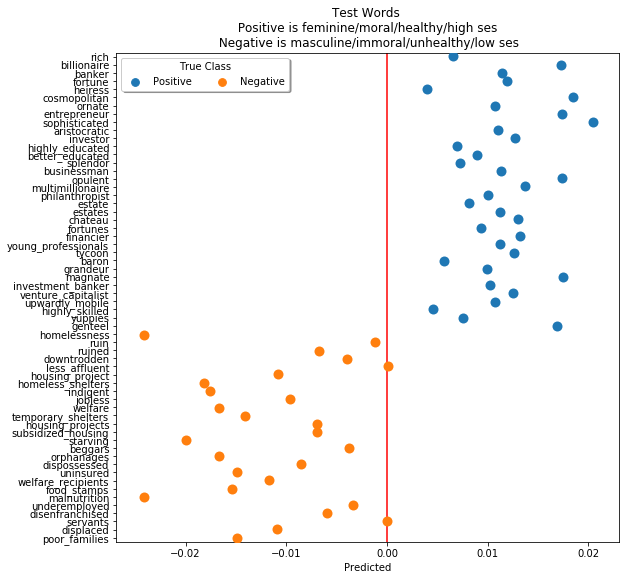

In [16]:
rcParams['figure.figsize'] = 9,9
#xlim([-.03, .03])

test_classes_relabeled=[] #quick hack to get legend to show Positive/Negative instead of 0/1
for i in test_classes:
    if i==1:
        test_classes_relabeled.append('Positive')
    else:
        test_classes_relabeled.append('Negative')
        
myplot= sns.stripplot(projections_test, test_word_list, test_classes_relabeled, jitter=True, size=10)
plt.legend(loc="upper left", bbox_to_anchor=[0, 1],
           ncol=2, shadow=True, title="True Class", fancybox=True)

plt.axvline(x=0, color='r', linestyle='-')
plt.title('Test Words \n Positive is feminine/moral/healthy/high ses \n Negative is masculine/immoral/unhealthy/low ses')
plt.xlabel('Predicted')
plt.show()

#### For gender, let's see how some stereotypicallly gendered words are classified with this method!
Try adding in other gender stereotypes here. 

In [123]:
gender_stereotypes=['petite', 'cooking', 'graceful','housework', 'soft', 'whisper', 'flirtatious', 'accepting', 'blonde', 'blond', 'doll', 'dolls','nurse',  'estrogen', 'lipstick','pregnant', 'nanny', 'pink', 
                 'sewing', 'modeling', 'dainty', 'gentle', 'children','pregnancy', 'nurturing', 'depressed', 'nice', 'emotional','depression', 'home', 'kitchen', 'quiet', 'submissive',
                   'soldier', 'army', 'drafted', 'military',   'beard', 'mustache', 'genius', 'engineering', 'math', 
                  'brilliant', 'strong', 'strength',  'politician', 'programmer','doctor', 'sexual', 'aggressive', 
                    'testosterone', 'tall', 'competitive', 'big', 'powerful', 'mean', 'sports', 'fighting', 'confident', 'rough', 'loud', 'worldly',
                   'experienced', 'insensitive', 'ambitious', 'dominant']
gender_stereotypes= []

#check if these words are in your model
for i in gender_stereotypes_seeifinmodel:
    try:
        currentmodel[i]
        gender_stereotypes.append(i)
    except:
        print(str(i) + " was not in this model's vocabulary and has been removed")
        continue
        
train_word_list, predictions_train, projections_train, train_classes, test_word_list, predictions_test, \
    projections_test, test_classes, predictions_new_word_list, projections_new_word_list  \
    = do_projections('gender', gender_stereotypes)
    
#Visualization
rcParams['figure.figsize'] = 9,9
#xlim([-.03, .03])
myplot= sns.stripplot(projections_new_word_list, gender_stereotypes, color= 'blue', jitter=True, size=10)
plt.axvline(x=0, color='r', linestyle='-')
plt.title('Predicted Gender of Stereotypically Gendered Words')
plt.xlabel('Negative projection is masculine, positive projection is feminine')
plt.show()

Number of pos words: 85 Number of neg words: 85
Number of test words: 60
Percent- Training accuracy: 0.905882352941 Testing accuracy: 0.933333333333
Number- Training accuracy: 154 Testing accuracy: 56


#### Now lets try with obese words:
Try plugging in your own words here too! Select below whether you want to look at these with respect to gender, moral, health, or ses:

Number of pos words: 81 Number of neg words: 81
Number of test words: 60
Percent- Training accuracy: 0.895061728395 Testing accuracy: 0.95
Number- Training accuracy: 145 Testing accuracy: 57


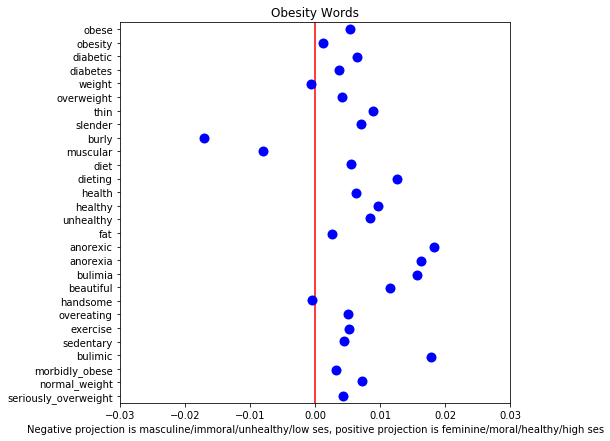

In [170]:
obese_words= ['obese', 'obesity', 'diabetic', 'diabetes', 'weight', 'overweight', 'thin', 'slender', 'burly',
                'muscular', 'diet', 'dieting', 'health', 'healthy', 'unhealthy', 'fat', 'anorexic', 'anorexia', 'bulimia', 
                'beautiful', 'handsome', 'overeating', 'exercise', 'sedentary', 'bulimic', 'morbidly_obese', 'normal_weight',
                'seriously_overweight']

obese_words= []

#check if these words are in your model
for i in obese_words_seeifinmodel:
    try:
        currentmodel[i]
        obese_words.append(i)
    except:
        print(str(i) + " was not in this model's vocabulary and has been removed")
        continue

train_word_list, predictions_train, projections_train, train_classes, test_word_list, predictions_test, \
    projections_test, test_classes, predictions_new_word_list, projections_new_word_list  \
    = do_projections('gender', obese_words)

#### Visualization based on the dimension you selected in the above code block

In [ ]:
rcParams['figure.figsize'] = 7, 7
xlim([-.03, .03])
myplot= sns.stripplot(projections_new_word_list, obese_words, color= 'blue', jitter=True, size=10)
plt.axvline(x=0, color='r', linestyle='-')
plt.title('Obesity Related Words \n Positive is feminine/moral/healthy/high ses \n Negative is masculine/immoral/unhealthy/low ses')
plt.xlabel('Predicted')
plt.show()

#### Write projection for training/testing/obese keywords results to a CSV

In [142]:
#written here for gender, or specify in "do_projections" below for moral, health, or ses
train_word_list, predictions_train, projections_train, train_classes, test_word_list, predictions_test, projections_test, test_classes, predictions_new_word_list, projections_new_word_list = do_projections('gender', obese_words)

with open(r'SES_GeomAlt_MEAN.csv', 'a') as f: #change as needed for Gender,Moral, Health, SES
    writer = csv.writer(f)
    writer.writerow(['SES_Train']*len(train_word_list))  #change the headings as needed for Gender,Moral, Health, SES
    writer.writerow(train_word_list)
    writer.writerow(train_classes)
    writer.writerow(predictions_train)
    writer.writerow(projections_train)
   
    writer.writerow(['SES_Test']*len(test_word_list)) #change the headings as needed for Gender, Moral, Health, SES
    writer.writerow(test_word_list)
    writer.writerow(test_classes)
    writer.writerow(predictions_test)
    writer.writerow(projections_test)
    
    writer.writerow(['SES_Obesity']*len(obese_words)) #change the headings as needed for Gender, Moral, Health, SES, and if another set of words other than the obese_words are used here
    writer.writerow(obese_words)
    writer.writerow(predictions_new_word_list)
    writer.writerow(projections_new_word_list)

Number of pos words: 50 Number of neg words: 50
Number of test words: 60
Percent- Training accuracy: 0.94 Testing accuracy: 0.966666666667
Number- Training accuracy: 94 Testing accuracy: 58
